**STEP 1: Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

**Step 2: Load Data**

In [2]:
df = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [5]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

**Step 3: Exploratory Data Analysis (EDA)**

**Class distribution**

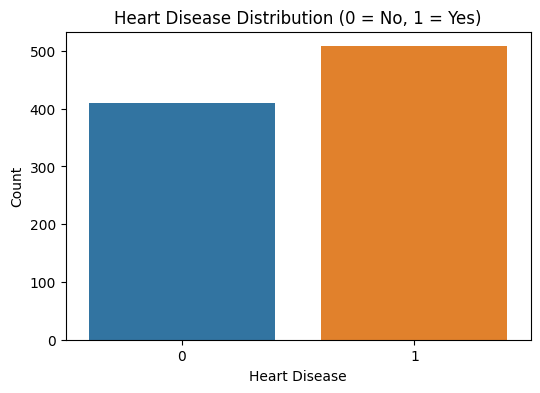

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(x='HeartDisease', data=df)
plt.title("Heart Disease Distribution (0 = No, 1 = Yes)")
plt.xlabel("Heart Disease")
plt.ylabel("Count")
plt.show()

**Distribution of Age**

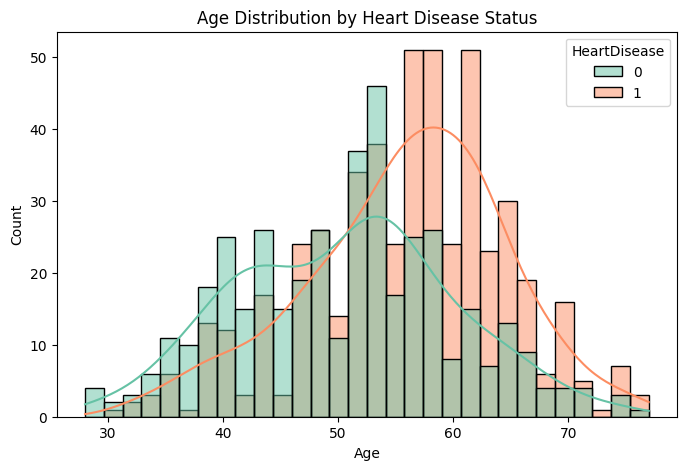

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Age', bins=30, kde=True, hue='HeartDisease', palette='Set2')
plt.title("Age Distribution by Heart Disease Status")
plt.show()

**Gender Distribution**

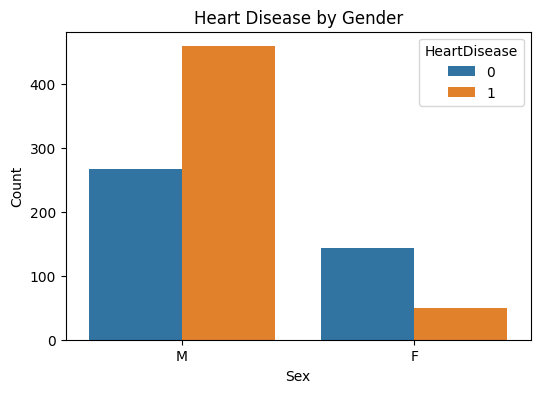

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Sex', data=df, hue='HeartDisease')
plt.title("Heart Disease by Gender")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

**Chest Pain Type**

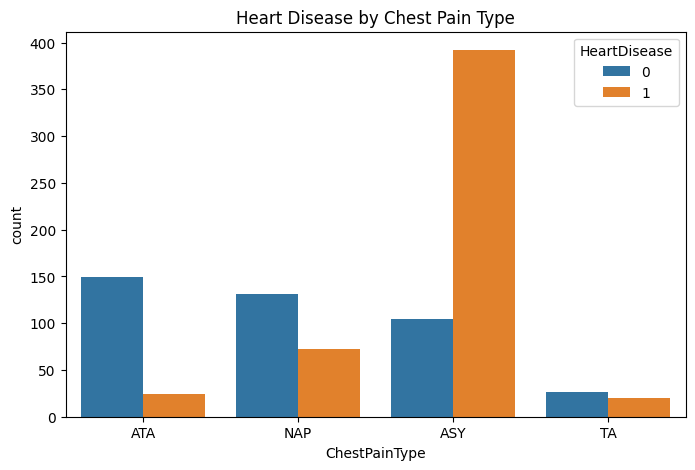

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x='ChestPainType', data=df, hue='HeartDisease')
plt.title("Heart Disease by Chest Pain Type")
plt.show()

**Pairplot for Numeric Features (sample only a few)**

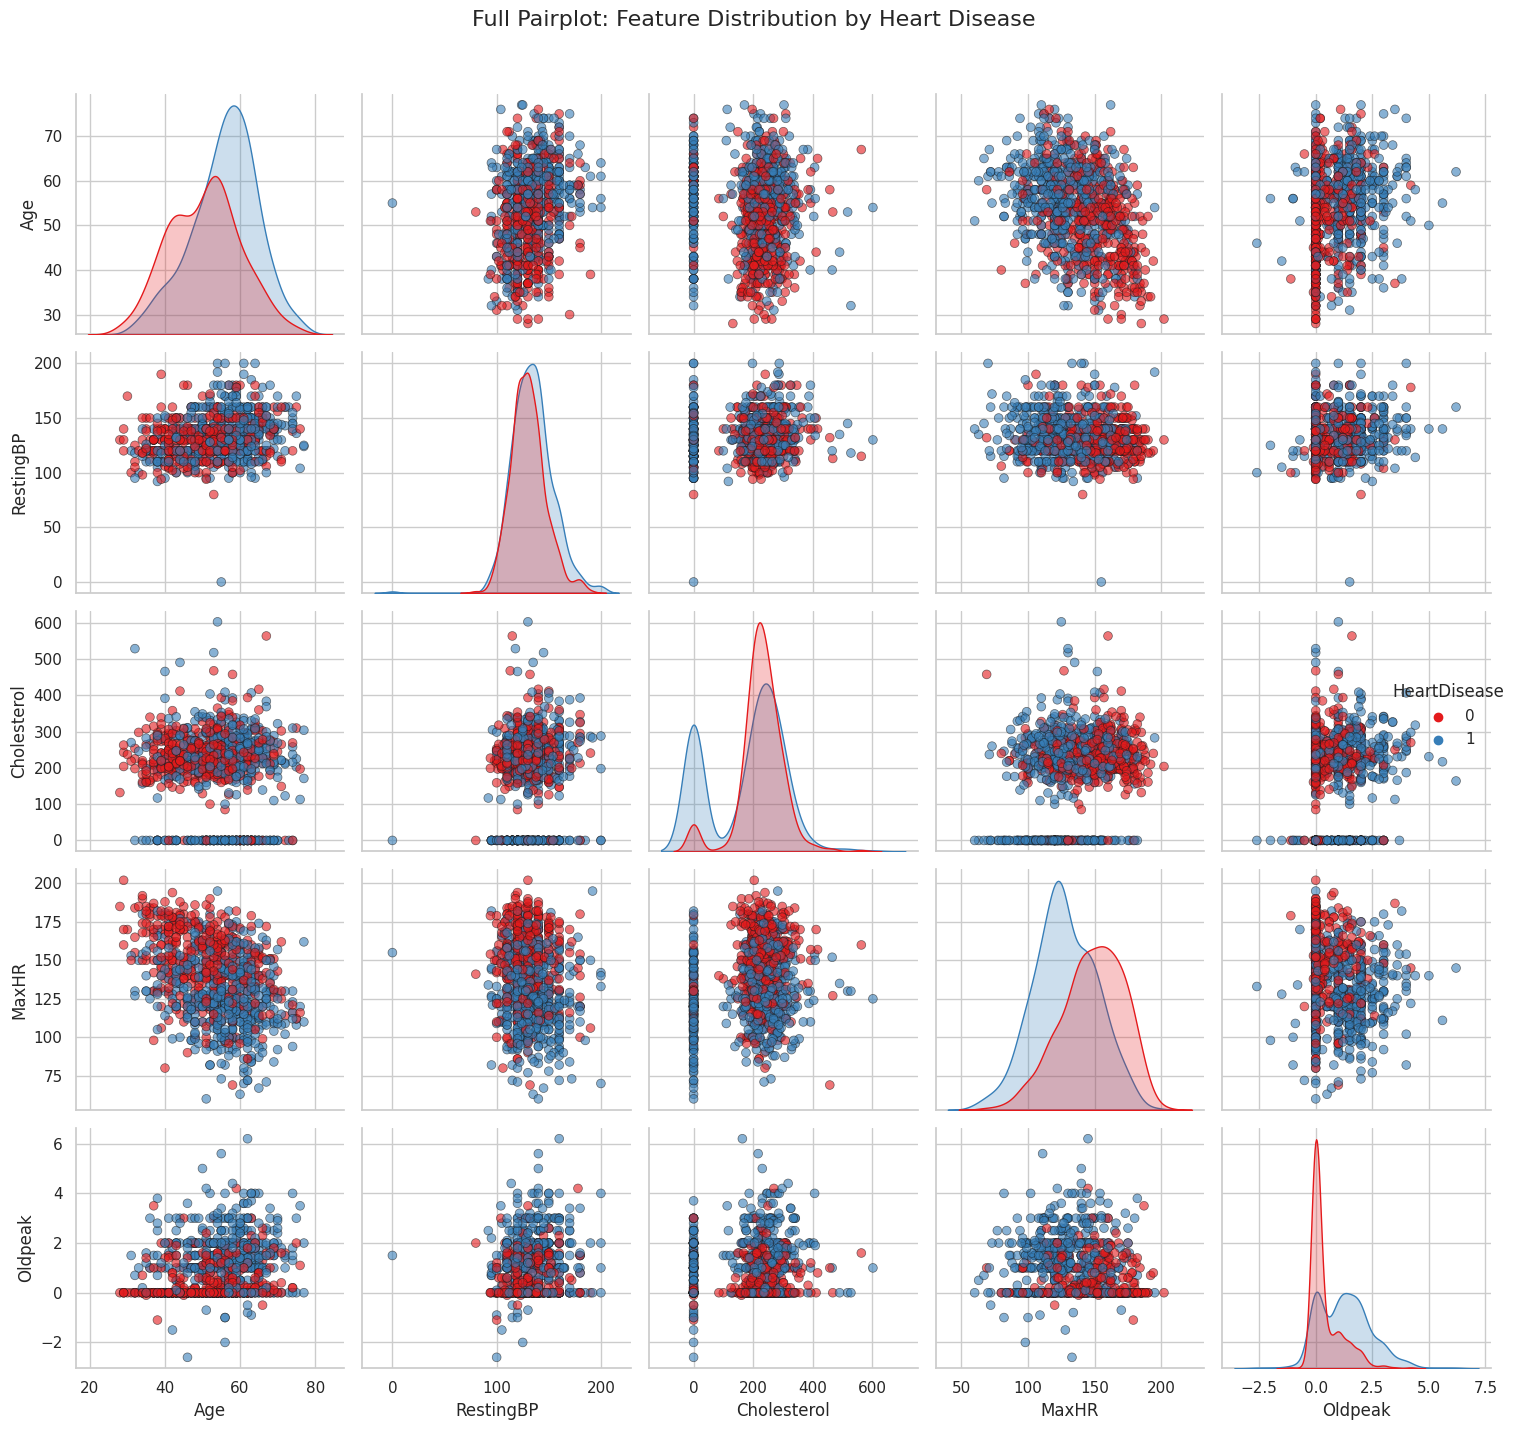

In [10]:
sns.set(style="whitegrid", context="notebook")
features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']
pair = sns.pairplot(
    df[features], hue='HeartDisease', palette='Set1', diag_kind='kde', plot_kws={'alpha': 0.6, 's': 40, 'edgecolor': 'k'}, height=2.8
)

pair.fig.suptitle("Full Pairplot: Feature Distribution by Heart Disease", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

**Correlation Heatmap**

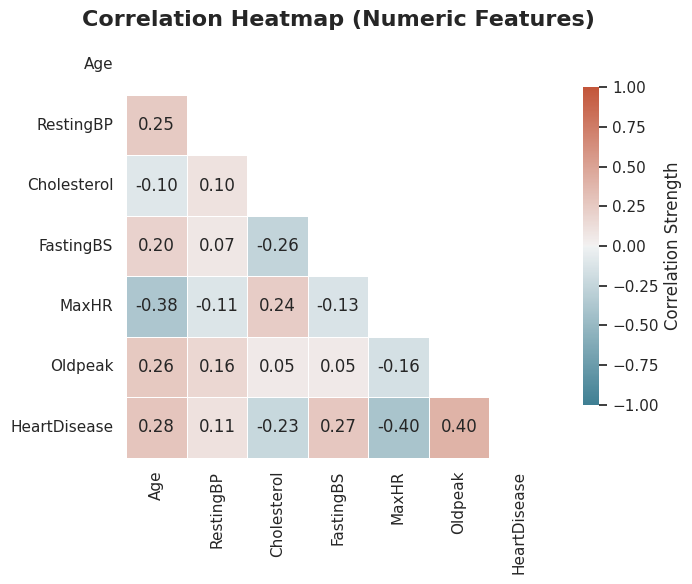

In [11]:
numeric_df = df.select_dtypes(include=["int64", "float64"])
corr = numeric_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(8, 6))
sns.set(style="white")
cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(
    corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0, annot=True, fmt=".2f", square=True,
    linewidths=0.5, cbar_kws={"shrink": 0.75, "label": "Correlation Strength"},
)
plt.title("Correlation Heatmap (Numeric Features)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

**STEP 4: Data Preprocessing**

In [12]:
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

numeric_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
categorical_features = [col for col in X.columns if col not in numeric_features]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="first", handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

**Step 5: Train-Test Split**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**STEP 6: Models Define**

In [14]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

**STEP 7: Train and Evaluation (without tuned)**

In [15]:
untuned_results = {}
for name, model in models.items():
    pipe = Pipeline([("pre", preprocessor), ("clf", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    untuned_results[name] = {
        "model": pipe,
        "accuracy": accuracy_score(y_test, y_pred),
        "conf": confusion_matrix(y_test, y_pred),
        "report": classification_report(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob),
        "roc_curve": roc_curve(y_test, y_prob)
    }

In [16]:
print("Untuned Model Accuracies:")
for name, result in untuned_results.items():
    print(f"{name}: {result['accuracy']:.4f}")

best_untuned_name, best_untuned_data = max(untuned_results.items(), key=lambda x: x[1]["accuracy"])
print(f"\nBest Untuned Model: {best_untuned_name} with Accuracy = {best_untuned_data['accuracy']:.4f}")

Untuned Model Accuracies:
Logistic Regression: 0.8533
Decision Tree: 0.8424
Random Forest: 0.8533
SVM: 0.8533
KNN: 0.8315
Gradient Boosting: 0.8641
XGBoost: 0.8587

Best Untuned Model: Gradient Boosting with Accuracy = 0.8641


**Confusion Matrix and Classifiction Report for untuned best model**

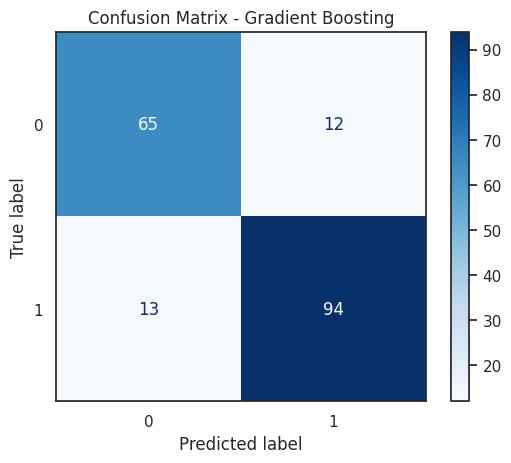

Classification Report - Gradient Boosting:

              precision    recall  f1-score   support

           0       0.83      0.84      0.84        77
           1       0.89      0.88      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



In [17]:
best_model_name, best_model_data = max(untuned_results.items(), key=lambda x: x[1]["accuracy"])

conf_matrix = best_model_data["conf"]
class_report = best_model_data["report"]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

print(f"Classification Report - {best_model_name}:\n")
print(class_report)


**ROC Curve**

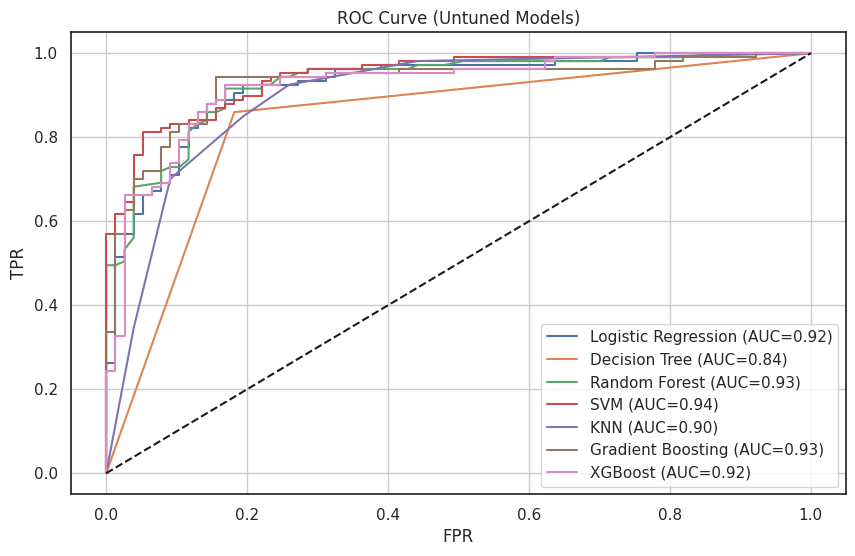

In [18]:
plt.figure(figsize=(10, 6))
for name, result in untuned_results.items():
    fpr, tpr, _ = result["roc_curve"]
    plt.plot(fpr, tpr, label=f"{name} (AUC={result['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (Untuned Models)")
plt.legend()
plt.grid(True)
plt.show()

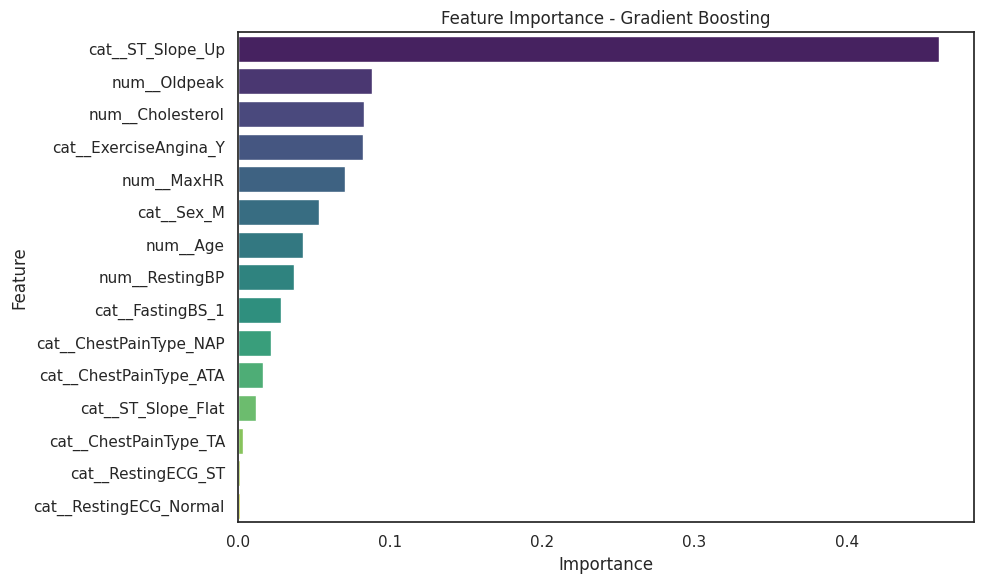

In [19]:
best_model = best_model_data["model"]
clf = best_model.named_steps['clf']

if hasattr(clf, 'feature_importances_'):
    importances = clf.feature_importances_
    features = preprocessor.get_feature_names_out()
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()
else:
    print("This model does not support feature importance.")

**Step 8: Parameter Define for All Models**

In [20]:
param_grids = {
    "Logistic Regression": {
        "clf__C": [0.01, 0.1, 1, 10], "clf__solver": ["liblinear", "lbfgs"]
    },
    "Decision Tree": {
        "clf__max_depth": [3, 5, 10, None], "clf__min_samples_split": [2, 5, 10], "clf__criterion": ["gini", "entropy"]
    },
    "Random Forest": {
        "clf__n_estimators": [50, 100, 200], "clf__max_depth": [None, 5, 10], "clf__min_samples_split": [2, 5], "clf__criterion": ["gini", "entropy"]
    },
    "SVM": {
        "clf__C": [0.1, 1, 10], "clf__kernel": ["linear", "rbf", "poly"], "clf__gamma": ["scale", "auto"]
    },
    "KNN": {
        "clf__n_neighbors": [3, 5, 7, 9], "clf__weights": ["uniform", "distance"], "clf__metric": ["euclidean", "manhattan"]
    },
    "Gradient Boosting": {
        "clf__n_estimators": [50, 100, 200], "clf__learning_rate": [0.01, 0.1, 0.2], "clf__max_depth": [3, 5]
    },
    "XGBoost": {
        "clf__n_estimators": [50, 100, 200], "clf__learning_rate": [0.01, 0.1, 0.2], "clf__max_depth": [3, 5, 7]
    }
}

**STEP 9: Train and Evaluation (with tuned)**

In [21]:
tuned_results = {}
for name, model in models.items():
    pipe = Pipeline([("pre", preprocessor), ("clf", model)])
    grid = GridSearchCV(pipe, param_grids[name], cv=3, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    y_prob = grid.predict_proba(X_test)[:, 1]

    tuned_results[name] = {
        "model": grid.best_estimator_,
        "accuracy": accuracy_score(y_test, y_pred),
        "conf": confusion_matrix(y_test, y_pred),
        "report": classification_report(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob),
        "roc_curve": roc_curve(y_test, y_prob)
    }

In [22]:
print("Tuned Model Accuracies:")
for name, result in tuned_results.items():
    print(f"{name}: {result['accuracy']:.4f}")

best_tuned_name, best_tuned_data = max(tuned_results.items(), key=lambda x: x[1]["accuracy"])
print(f"\nBest Tuned Model: {best_tuned_name} with Accuracy = {best_tuned_data['accuracy']:.4f}")

Tuned Model Accuracies:
Logistic Regression: 0.8533
Decision Tree: 0.8533
Random Forest: 0.8696
SVM: 0.8533
KNN: 0.8641
Gradient Boosting: 0.8750
XGBoost: 0.8804

Best Tuned Model: XGBoost with Accuracy = 0.8804


**Confusion Matrix and Classifiction Report for tuned best model**

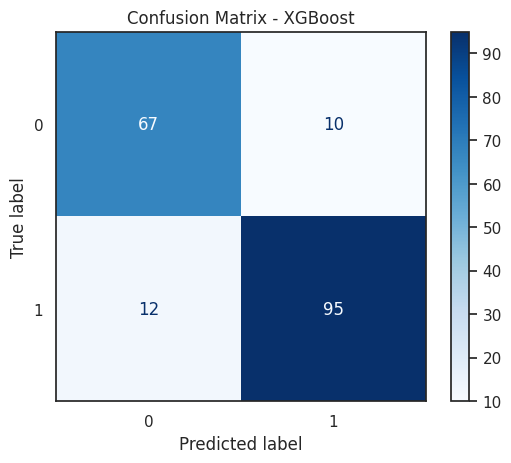

Classification Report - XGBoost:

              precision    recall  f1-score   support

           0       0.85      0.87      0.86        77
           1       0.90      0.89      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



In [23]:
best_model_name, best_model_data = max(tuned_results.items(), key=lambda x: x[1]["accuracy"])
conf_matrix = best_model_data["conf"]
class_report = best_model_data["report"]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

print(f"Classification Report - {best_model_name}:\n")
print(class_report)

**ROC Curve**

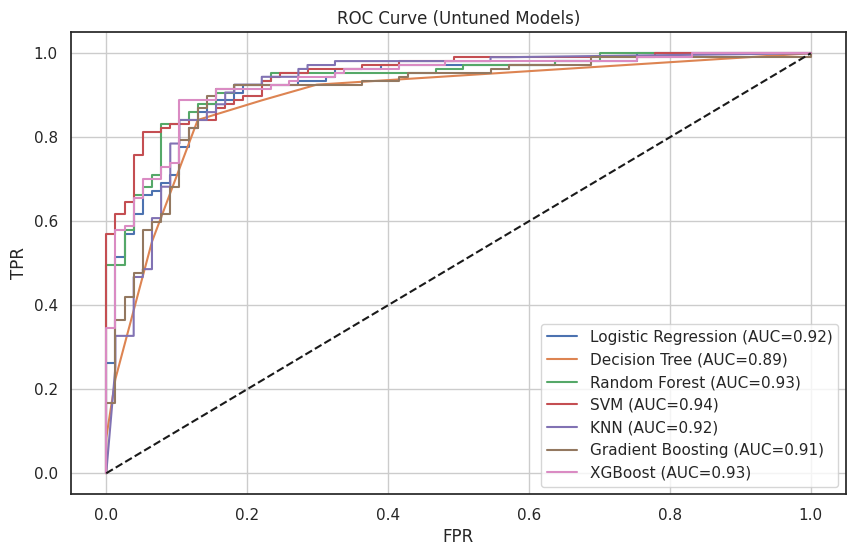

In [24]:
plt.figure(figsize=(10, 6))
for name, result in tuned_results.items():
    fpr, tpr, _ = result["roc_curve"]
    plt.plot(fpr, tpr, label=f"{name} (AUC={result['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (Untuned Models)")
plt.legend()
plt.grid(True)
plt.show()

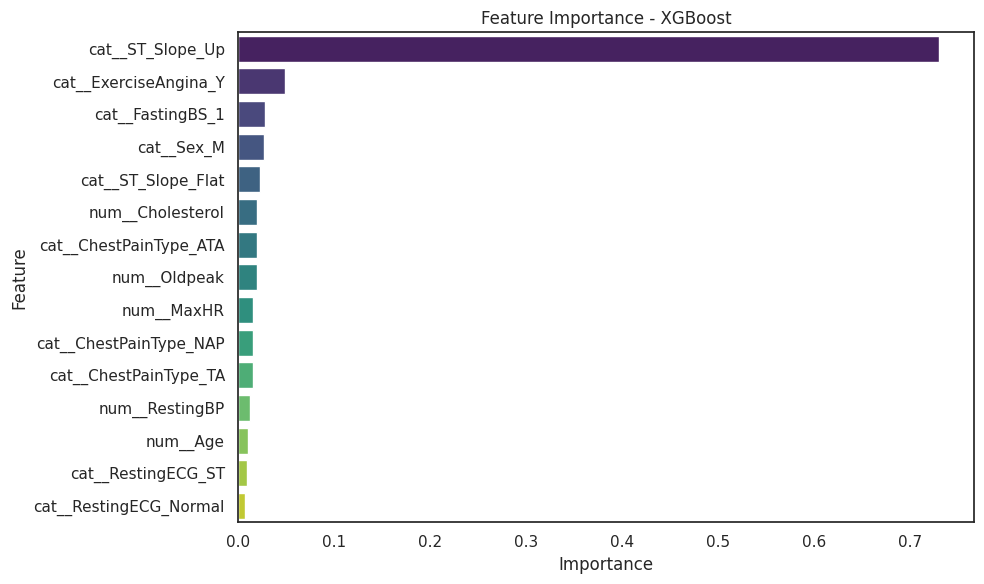

In [25]:
best_model = best_model_data["model"]
clf = best_model.named_steps['clf']

if hasattr(clf, 'feature_importances_'):
    importances = clf.feature_importances_
    features = preprocessor.get_feature_names_out()
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()
else:
    print("This model does not support feature importance.")

**Step 10: Model Accuracy Comparison**

In [26]:
comparison_df = pd.DataFrame({
    "Model": list(models.keys()),
    "Accuracy (Untuned)": [untuned_results[m]["accuracy"] for m in models.keys()],
    "Accuracy (Tuned)": [tuned_results[m]["accuracy"] for m in models.keys()]
}).sort_values(by="Accuracy (Tuned)", ascending=False)

print("\nAccuracy Comparison Table:")
print(comparison_df)


Accuracy Comparison Table:
                 Model  Accuracy (Untuned)  Accuracy (Tuned)
6              XGBoost            0.858696          0.880435
5    Gradient Boosting            0.864130          0.875000
2        Random Forest            0.853261          0.869565
4                  KNN            0.831522          0.864130
0  Logistic Regression            0.853261          0.853261
1        Decision Tree            0.842391          0.853261
3                  SVM            0.853261          0.853261


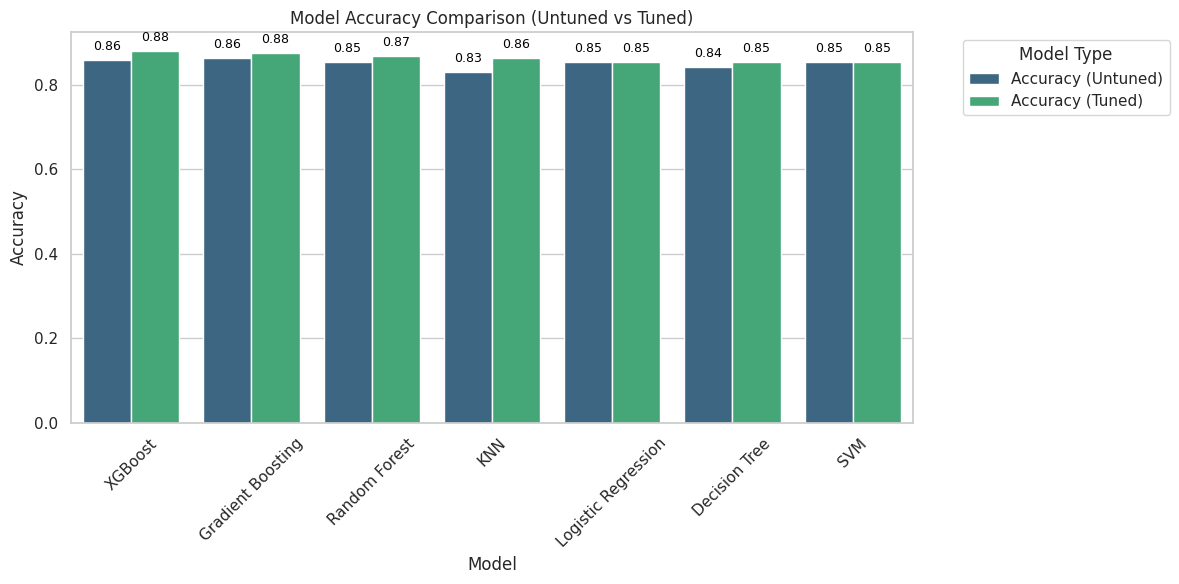

In [27]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

bar = sns.barplot(
    data=comparison_df.melt(id_vars="Model", var_name="Tuning", value_name="Accuracy"),
    x="Model", y="Accuracy", hue="Tuning", palette="viridis" )

for p in bar.patches:
    height = p.get_height()
    bar.annotate(f'{height:.2f}', 
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 5),
                 textcoords='offset points')

plt.legend(title="Model Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Model Accuracy Comparison (Untuned vs Tuned)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Step 11: Prediction Data**

In [28]:
best_tuned_name, best_tuned_data = max(tuned_results.items(), key=lambda x: x[1]["accuracy"])

sample = X_test.iloc[:10]
true_vals = y_test.iloc[:10]
pred_untuned = best_untuned_data["model"].predict(sample)
pred_tuned = best_tuned_data["model"].predict(sample)

prediction_df = pd.DataFrame({
    "Actual": true_vals.values,
    f"{best_untuned_name} (Untuned)": pred_untuned,
    f"{best_tuned_name} (Tuned)": pred_tuned
})

print("\nPrediction Comparison Table:")
print(prediction_df)


Prediction Comparison Table:
   Actual  Gradient Boosting (Untuned)  XGBoost (Tuned)
0       0                            0                0
1       1                            1                1
2       1                            1                1
3       1                            1                1
4       0                            0                0
5       1                            1                1
6       1                            1                1
7       0                            0                0
8       1                            1                1
9       1                            1                1
